In [1]:
import boto3
import matplotlib.pyplot as plt

s3 = boto3.client("s3")

# L0RP Bucket Location
bucket = "dev-usgs-landsat-level-0"
prefix = "l0rp/oli-tirs/"
l0rp_location = bucket + '/' + prefix


def list_objects(s3_location):
    bucket, prefix = s3_location.split("/", 1)
    objects = []
    continuation_token = {}
    while True:
        try:
            response = s3.list_objects_v2(
                Bucket=bucket, Prefix=prefix, **continuation_token
            )
           
            if response['KeyCount'] == 0:
                print(f'{s3_location} does not exist')
                break
            
            objects.extend(response["Contents"])

            if "NextContinuationToken" in response:
                continuation_token["ContinuationToken"] = response[
                    "NextContinuationToken"
                ]
            else:
                break

        except Exception as e:
            break

    return objects


def get_scene_id(key):
    if "Key" in key:
        return key["Key"].rsplit("/", 1).pop().split("_", 1)[0]
    else:
        return key.rsplit("/", 1).pop().split("_", 1)[0]

    
def get_scenes_from_path_row(path, row, year):
    s3_location = f"{l0rp_location}{year}/{path}/{row}/"
    
    return [get_scene_id(scene) for scene in list_objects(s3_location)]

def get_scenes(year, path_row_list=None):
    if path_row_list is None:
        s3_location = l0rp_location + year
        return list(map(get_scene_id, list_objects(s3_location)))
    else:
        scenes = []
        for path_row in path_row_list:
            path = str(path_row)[0:3]
            row = str(path_row)[3:6]
            scenes.extend(get_scenes_from_path_row(path.zfill(3), row.zfill(3), year))

        return scenes

## L0RP Products By Year 

In [2]:
num_of_scenes = {}
for year in range(2013, 2019+1):
     num_of_scenes[year] = len(get_scenes(str(year)))

num_of_scenes

{2013: 144703,
 2014: 237770,
 2015: 252980,
 2016: 256551,
 2017: 250167,
 2018: 261502,
 2019: 152905}

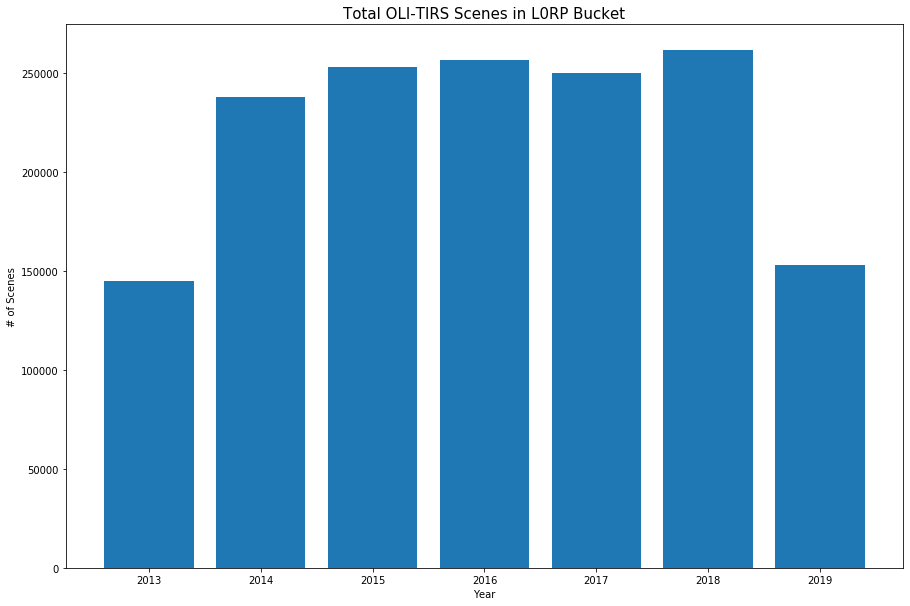

In [3]:
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.bar(range(len(num_of_scenes)), list(num_of_scenes.values()), align='center')
plt.xticks(range(len(num_of_scenes)), list(num_of_scenes.keys()))
plt.title('Total OLI-TIRS Scenes in L0RP Bucket', fontsize=15)
plt.xlabel('Year')
plt.ylabel('# of Scenes')
plt.show()

## Number of Nigeria Scenes

In [4]:
import requests as r

# Nigeria Path/Row List
nigeria_path_row_list = r.get(
    "https://raw.githubusercontent.com/tonybutzer/espaDog/master/service/order/wip/nigeria/nigeria_order_list.txt"
).text.split()

# Remove '/'
nigeria_path_row_list = [path_row.replace('/', '') for path_row in nigeria_path_row_list]

nigeria_scenes = get_scenes('2018', nigeria_path_row_list)
print('# of Nigeria scenes {}'.format(len(nigeria_scenes)))

# of Nigeria scenes 787


## Generate Nigeria Scene List

In [5]:
# Generate scene list for nigeria
def write_to_s3(body, s3_location):
    bucket, key = s3_location.split('/', 1)
    return s3.put_object(
        Body=body,
        Bucket=bucket,
        Key=key
    )

def generate_scene_list(scenes, tram_code, s3_location):
    scenes = [scene + "," + tram_code for scene in scenes]
    scenes = '\n'.join(scenes)
    result = write_to_s3(scenes, s3_location)
    
    if result['ResponseMetadata']['HTTPStatusCode'] == 200:
        return 'Success'
    else:
        return result

tram_code = 'XO220'
s3_location = 'dev-cmahan-test/matt/nigeria_scene_list.txt'

generate_scene_list(nigeria_scenes, tram_code, s3_location)

'Success'

## Number of Africa Scenes

In [6]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

df = pd.read_excel('Africa.xlsx')

africa_path_row_list = df['Unnamed: 2'].tolist()

africa_scenes = get_scenes('2018', africa_path_row_list)
print('Number of Africa scenes: {}'.format(len(africa_scenes)))


dev-usgs-landsat-level-0/l0rp/oli-tirs/2018/160/054/ does not exist
dev-usgs-landsat-level-0/l0rp/oli-tirs/2018/161/077/ does not exist
dev-usgs-landsat-level-0/l0rp/oli-tirs/2018/176/084/ does not exist
dev-usgs-landsat-level-0/l0rp/oli-tirs/2018/177/082/ does not exist
dev-usgs-landsat-level-0/l0rp/oli-tirs/2018/206/048/ does not exist
dev-usgs-landsat-level-0/l0rp/oli-tirs/2018/206/049/ does not exist
Number of Africa scenes: 29676


## Missing Scenes for 2018
* Path: 160 Row: 054
* Path: 161 Row: 077
* Path: 176 Row: 084
* Path: 177 Row: 082
* Path: 206 Row: 048
* Path: 206 Row: 049

## Generate Africa Scene List 

In [7]:
tram_code = 'XO220'
s3_location = 'dev-cmahan-test/matt/africa_scene_list.txt'

generate_scene_list(africa_scenes, tram_code, s3_location)

'Success'

In [9]:
len(africa_scenes)


29676